## Getting set up
Below we're going to load some libraries and the revised version of one of the functions used to calculate gas exchange.

In [1]:
k.read.fixed<-function (wnd.z, Kd, lat, lake.area, atm.press, dateTime, Ts, 
                        z.aml, airT, wnd, RH, sw, lwnet) 
{
  Kelvin <- 273.15
  emiss <- 0.972
  S_B <- 5.67e-08
  vonK <- 0.41
  dT <- 0.5
  C1 <- 114.278
  nu <- 0.29
  KeCrit <- 0.18
  albedo_SW <- 0.07
  swRat <- 0.46
  g <- 9.81
  C_w <- 4186
  mnWnd <- 0.2
  rpcI <- wnd < mnWnd
  wnd[rpcI] <- mnWnd
  mm <- calc.zeng(dateTime, Ts, airT, wnd, RH, atm.press, wnd.z)
  C_D <- mm$C_D
  E <- mm$alh
  H <- mm$ash
  dUdt <- sw * 0.93 - E - H + lwnet
  Qo <- sw * (1 - albedo_SW) * swRat
  rho_w <- water.density(Ts)
  if (wnd.z != 10) {
    e1 <- sqrt(C_D)
    wnd <- wnd/(1 - e1/vonK * log(10/wnd.z))
  }
  rhoAir <- 1.2
  tau <- C_D * wnd^2 * rhoAir
  uSt <- sqrt(tau/rho_w)
  q1 <- 2 - 2 * exp(z.aml * -Kd)
  q2 <- z.aml * Kd
  q3 <- exp(z.aml * -Kd)
  H_star <- dUdt - Qo * (q1/q2 - q3)
  thermalExpFromTemp <- function(Ts) {
    V <- 1
    dT <- 0.001
    T1 <- water.density(Ts)
    T2 <- water.density(Ts + dT)
    V2 <- T1/T2
    dv_dT <- (V2 - V)/dT
    alpha <- dv_dT
    return(alpha)
  }
  tExp <- thermalExpFromTemp(Ts)
  B1 <- H_star * tExp * g
  B2 <- rho_w * C_w
  Bflx <- B1/B2
  ltI <- Bflx > 0
  B1 <- Bflx
  B1[ltI] <- 0
  divi <- 1/3
  w1 <- -B1 * z.aml
  wSt <- w1^divi
  getKinematicVis <- function(Ts) {
    tempTable <- seq(0, 100, by = 5)
    visTable <- c(1.792, 1.519, 1.308, 1.141, 1.007, 0.897, 
                  0.804, 0.727, 0.661, 0.605, 0.556, 0.513, 0.477, 
                  0.444, 0.415, 0.39, 0.367, 0.347, 0.328, 0.311, 0.296)
    v <- data.frame(approx(tempTable, visTable, xout = Ts))[2]
    v <- v * 1e-06
    return(v)
  }
  kinV <- getKinematicVis(Ts)
  KeDe <- (kinV * g)
  KeNm <- uSt^3
  Ke <- KeNm/KeDe
  tau <- tau
  euPw <- (1 + Ke/KeCrit)
  tau_t <- tau/euPw
  uTanS <- tau_t/rho_w
  uTanS <- uTanS^0.5
  Sv <- C1 * kinV/uTanS
  eu_N <- uTanS^3
  eu_D <- vonK * Sv
  eu_0 <- eu_N/eu_D
  ew_0 <- -1 * B1
  e_0 <- ew_0 + eu_0
  K1 <- e_0 * kinV
  K2 <- ew_0 * kinV
  K1 <- K1 * 100^4 * 3600^4
  K2 <- K2 * 100^4 * 3600^4
  K600 <- nu * 600^(-0.5) * K1^(1/4)
  k600 <- as.numeric(K600$y)
  k600 <- k600 * 24/100
  return(k600)
}

library(tidyr)
library(dplyr)# clean data
library(tidyr)# clean data
library(rLakeAnalyzer)# lake analyses
library(lubridate)# working with time
library(LakeMetabolizer)# lake analyses
library(curl)
library(ggplot2)
library(readr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Using libcurl 8.7.1 with LibreSSL/3.3.6


Attaching package: ‘readr’


The following object is masked from ‘package:curl’:

    parse_date




## Ecosystem metabolism in lakes
Ecosystem metabolism is a critical concept and measurement that allows researchers to model the productivity, respiration, and carbon cycling of an ecosystem.

We are going to model ecosystem metabolism in lakes using the R package _LakeMetabolizer_ developed by USGS and collaborators. Current ecosystem metabolism methods in aquatic ecosystems using dissolved oxygen time series to infer rates of primary production and _aerobic_ respiration.


<div>
<img src="images/streammetabolism.png" width="500"/>
</div>

This method works by comparing the rate of oxygen increase during the day, when both photosynthesis and respiration are occurring, versus the night, where only respiration is active. We use the equation below to assess how oxygen changes vary with light while taking into account gas exchange between the water and the air across the water surface.

$$ \Delta m_{O_i,d} = \left( \frac{GPP_d}{Z_{i,d}} \times \frac{PPFD_{i,d}}{PPFD_d} + \frac{ER_d}{Z_{i,d}} + f_{i,d}(K600_d)(O_{sat,i,d}-m_{O_i,d}) \right) \times \Delta t $$

Here is mO<sub>i,d</sub> is modeled DO concentration for timestep i on day _d_, Osat<sub>i,d</sub> is DO saturation for timestep _i_ on day _d_. Δt is the length of each time step (60 minutes in our example), GPP<sub>d</sub> and ER<sub>d</sub> are average GPP and ER (both in g-O<sub>2</sub> m<sup>-2</sup> d<sup>-1</sup>) on day _d_. _z<sub>i,d</sub> is average cross-sectional depth of each upstream. _K600<sub>d</sub> is estimated standardized gas exchange rate (d<sup>-1</sup>) scaled to the Schmidt number 600 on day _d_. _PFFD<sub>i,d</sub> is photosynthetic photon flux density at timestep _i_ on day _d_. <span style="text-decoration:overline">PPFD<sub>d</sub></span> represents the sum of solar insolation for day _d_.

## Lake metabolism specifics
The concept behind ecosystem metabolism estimates in lakes is the same as that used for streams and rivers, but the demands in terms of modeling and data are different. The key variable that is important here is gas exchange, which is parameterized by _K600<sub>d</sub>, which captures the rate of gas exchange between air and water. In streams and rivers, gas exchange is primarily driven by turbulence, which varies predictably with river flow rate. By contrast, in lake ecosystems, wind driven turbulence, solar convection, water color, and lake size all determine the rate of gas exchange. Thus, a number of variables are required to fully quantify gas exchange in lakes.

<div>
<img src="images/lakemetabolism.png" width="1000"/>
</div>

## Loading data
Here we are loading two data files. The first is called crooked_buoy

In [4]:
buoyWide=read_csv('files/lake_metabolism/Sparkling2014wtemp_hourly_wide.csv')
#met=read_csv('~/metabolism_modeling/Sparkling2014met_hourly.csv')
#metData<-met%>%dplyr::select(sampledate,air_temp,rel_hum,wind_speed_2m,par,opt_wtemp,opt_do_raw)
#metData<-readRDS("~/modules/cybertraining_ecology/Level 2/files/lake_metabolism/metData.rds")
metData<-readRDS("files/lake_metabolism/metData.rds")

datetime=metData$sampledate
do.obs=metData$opt_do_raw

Rows: 2532 Columns: 29
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl  (28): wtr_0, wtr_0.25, wtr_0.5, wtr_0.75, wtr_1, wtr_1.5, wtr_2, wtr_2....
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## calculate dissolved oxygen saturation.
As you can see from the equation above, ecosystem metabolism calculations are based on dissolved oxygen percent saturation, not the concentration of dissolved oxygen. We can use atmospheric pressure, elevation, and water temperature to determine dissolved oxygen saturation.

In [5]:
do.sat=o2.at.sat.base(metData$opt_wtemp, altitude=300)

## Lake stratification
Lakes often undergo seasonal stratification driven by different temperatures. As seen in the above image, warm season stratification results in three layers. The top layer is the epilimnion. This layer has warm water and light exposure and is thus where essentially all photosynthesis occurs in a stratified lake. The middle layer transitioning from the warm surface layer to the cool deeper layer is called the metalimion. The cool bottom layer is known as the hypolimnion and is typically a dark environment where oxygen supplies can be limited.

We need to quantify the depth of stratification to determine the volume of water near the surface where photosynthesis is occuring. We can do that with one of those cool lake heat maps with temperature data distributed by depth over time.

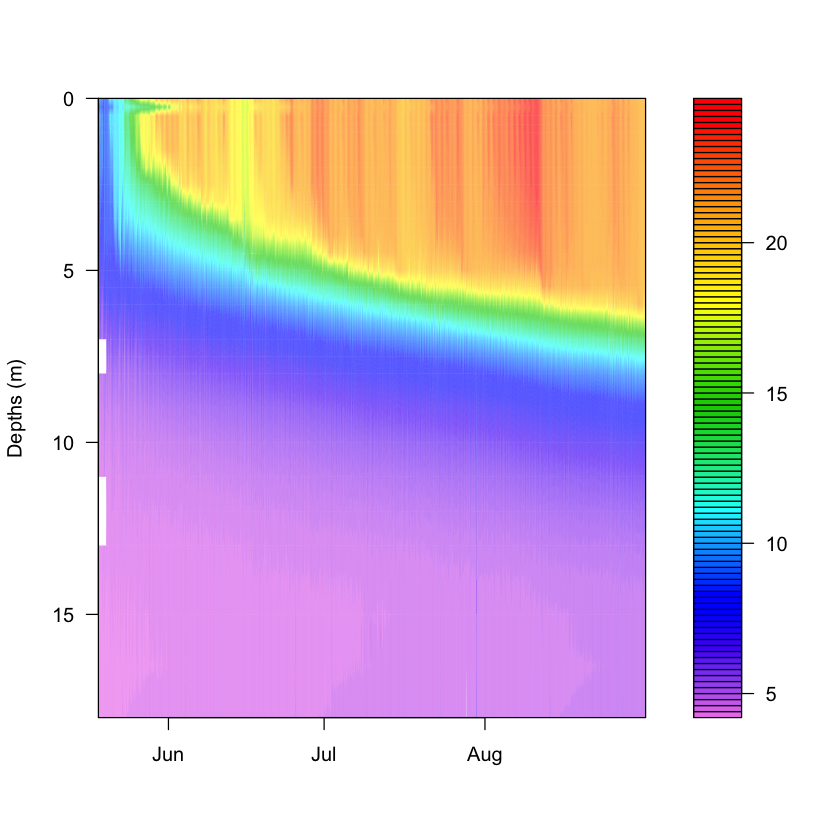

In [6]:
wtr.heat.map(wtr=as.data.frame(buoyWide))

The area where temperatures transition abruptly is the metalimnion. Water located above the metalimnion is by definition the epilimnion. Thus, to determine the epilimnion, we need only identify the metalimnion. One could do this visually or with a novel algorhithm, but fortunately there is function available that uses the slope a temperature profile to detect the top, bottom, and center of the lake metalimnion.

## Metaliminion plot

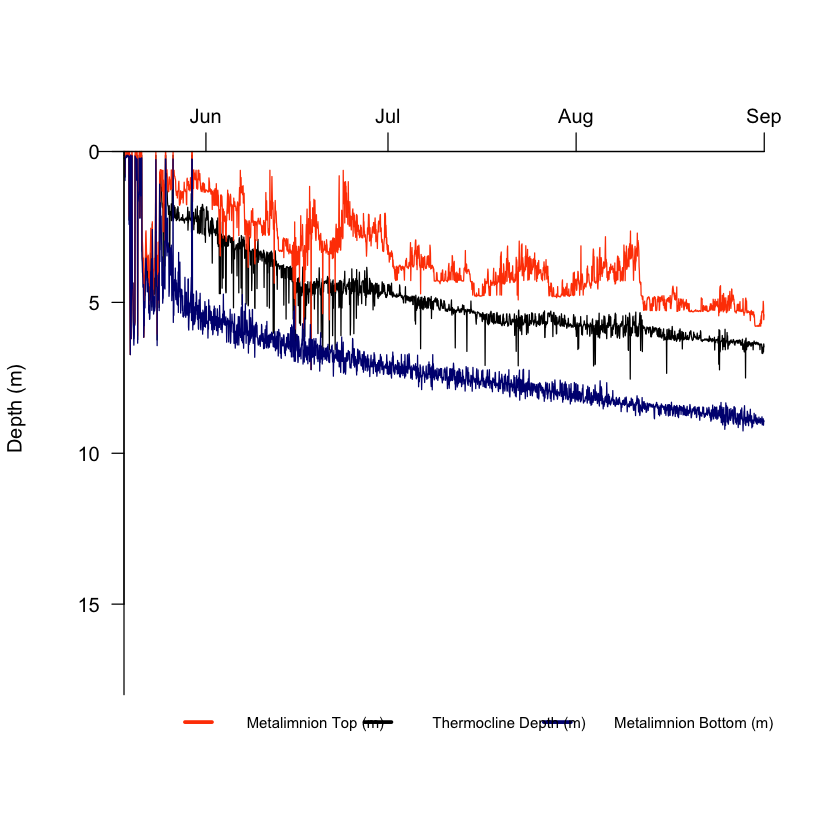

In [7]:
options(warn=-1)


#this command uses temperatures arranged by depth to determine where the metalimnion is.
wtr.plot.temp(wtr=as.data.frame(buoyWide),na.rm=T)

### Crooked Lake Plots

ERROR: Error in gzfile(file, "rb"): cannot open the connection


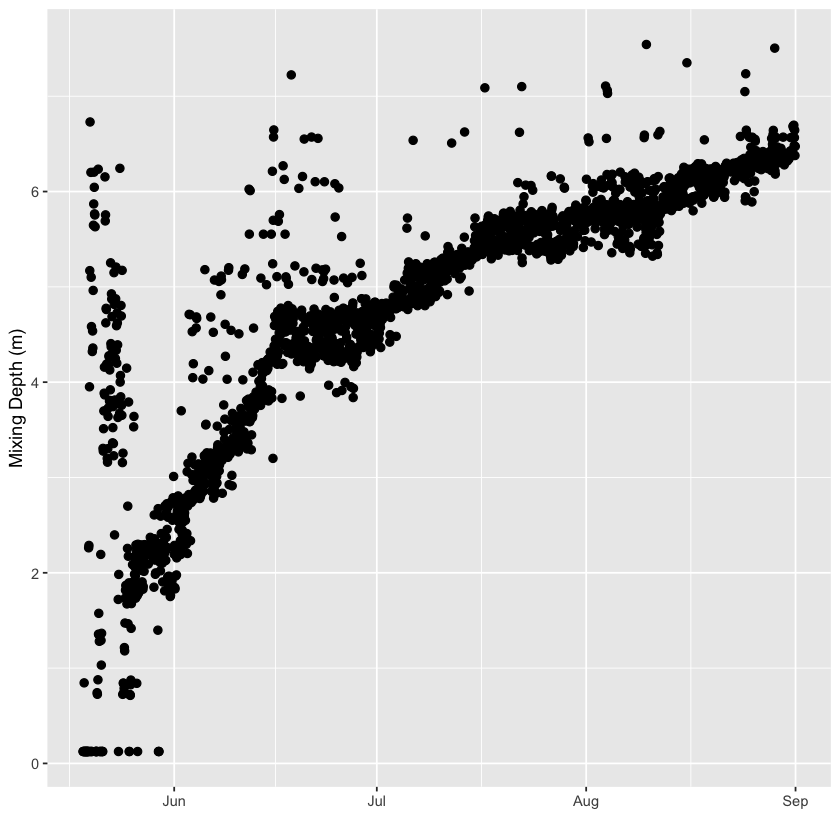

In [8]:
#now we can use this model to find a depth for the thermocline and then plot it.
#Why does the trend in this plot look the opposite of the one you saw in the other plots and can you think of any ways to fix that?
z.mix=ts.thermo.depth(wtr=buoyWide,na.rm=T)[,2]
z.mix.df<-data.frame(datetime=buoyWide$datetime,z.mix=z.mix)
ggplot(z.mix.df,aes(datetime,z.mix))+
  geom_point(size=2)+
  xlab("")+
  ylab("Mixing Depth (m)")

#now we're going to look at temperature data for Crooked Lake
crooked_lake<-readRDS("~/modules/cybertraining_ecology/Level 2/files/lake_metabolism/crooked_lake_temp.rds")

#we can do another one of those cool lake heat maps with temperature data distributed by depth.
wtr.heat.map(wtr=as.data.frame(crooked_lake))


#this command uses temperatures arranged by depth to determine where the metalimnion is.
wtr.plot.temp(wtr=as.data.frame(crooked_lake),na.rm=T)

In [ ]:
#this plots a section of the Photosynthetically Active Radiation (sunlight) data that we use to help us model photosynthesis.
ggplot(metData,aes(sampledate,par))+
  geom_point(size=2)+
  xlab("")+
  ylab(expression("Photosyntically Active Radiation ("*mu*"moles "*m^-2*s^-1*")"))+
  geom_line()+
  scale_x_datetime(date_breaks = "1 month", 
                   limits = as.POSIXct(c('2014-06-15','2014-07-01')))

In [ ]:
#try seeing if you can use the scale command to zoom in and out to look at the data in more or less detail.

#extracting PAR as a separate variable
par=metData$par
# For bookeeping irradiance this tells us if it is day (value = 1) or night (value = 0)
isday=is.day(metData$sampledate,48)
dayIrr=rep(0,nrow(metData))
dayIrr[isday]=1

#Remember that oxygen diffuses 10,000x more slowly through water than through air. That means that we have to figure out how much air is mixing with water. We do that by estimating a variable called k that is measured in meters per day (the vertical velocity of gas exchange).
#There are a number of data ways that you can measure gas exchange  developed by different researchers. Type "?k.cole.base" (without the quotes) in the R console to get the help file that explains these different methods. We will start with k.cole.base, which uses an early, simplified algorithm by Jon Cole. This method is simple and only uses temperature of water to measure gas exchange. More recently, Jordan Read of the USGS has developed a more sophisticated equation for estimating gas exchange that also takes into account wind speed, lake size and other important variables to create a better estimate.

#First we have to correct the wind data based on the height it was measured.
U10<-wind.scale.base(wnd=metData$wind_speed_2m, wnd.z=2)

#The Read model also uses visible light (shortwave radiation) and infrared light (longwave radiation) to estimate the amount of solar heating of the water since this influences convective mixing. We are using Photosynthetically Active Radiation (PAR) as shortwave radiation because they are pretty close. We're using shortwave radiation, air temperature above the lank, and humidity to estimate longwave radiation since no sensor of that type was deployed.

# Calculate shortwave radiation
sw=par.to.sw.base(metData$par)

# Calculate longwave radiation
airtemp=metData$air_temp
#here we are using water temperature at 0.5m for wtr (water temperature).
wtr=buoyWide$wtr_0.5
rh=metData$rel_hum
lwnet=calc.lw.net.base(datetime,sw,wtr,48,1013,airtemp,rh)

radiation_results<-data.frame(datetime=metData$sampledate,lwnet=lwnet,sw=sw)

library(reshape2)
rad_results_melt<-melt(radiation_results,id=c("datetime"))
ggplot(rad_results_melt,aes(datetime,value,color=variable,group=variable))+
  geom_point(size=2)+
  xlab("")+
  ylab(expression("Watts "*m^-2))

#That probably looks too crowded, we can break-up these plots with the facet_wrap() command

ggplot(rad_results_melt,aes(datetime,value,color=variable,group=variable))+
  geom_point(size=2)+
  facet_wrap(.~variable)+
  xlab("")+
  ylab(expression("Watts "*m^-2))

#try using the scale_x_datetime command I introduced before to narrow the date range you show on the graph


### Calculating Metabolism

In [ ]:
# k600 Cole
k600.cole=k.cole.base(U10)
# k600 Read
k600.read=k.read.fixed(wnd.z=10,Kd=2,lat=48,lake.area=5000,atm.press=1013,dateTime=datetime,Ts=wtr,z.aml=z.mix,airT=airtemp,wnd=U10,RH=rh,sw=sw,lwnet=lwnet)

# k.gas flux converted from K600 (standardized) to K for O2.
kgas.cole=k600.2.kGAS.base(k600.cole, wtr, 'O2')
kgas.read=k600.2.kGAS.base(k600.read, wtr, 'O2')

#now we are actually calculating metabolism with Maximum Likelihood Estimation and the Cole K method.
metab.mle(do.obs, do.sat, kgas.cole, z.mix, par, wtr)

#this just gives us an overall estimate, now let's look at individual days. The function below will do that.

metab.estimates<-function(kgas,metData){
  # Setup empty data.frame for three months
  output=data.frame(date=seq.Date(as.Date('2014-06-01'),as.Date('2014-08-31'),by='day'),NEP.mle=NA, NEP.ols=NA, NEP.kalman=NA, NEP.bookkeep=NA)
                    
                    # Loop through each day.
                    for(i in 1:nrow(output)){
                      # Create a index for each day, so only those days values will be used
                      indx<-as.Date(metData$sampledate)==output$date[i]
                      
                      m.mle=metab.mle(do.obs[indx], do.sat[indx], kgas[indx], z.mix[indx],par[indx],wtr[indx])
                      m.ols=metab.ols(do.obs[indx], do.sat[indx], kgas[indx], z.mix[indx],par[indx],wtr[indx])
                      m.kal=metab.kalman(do.obs[indx], do.sat[indx], kgas[indx], z.mix[indx], par[indx],wtr[indx])
                      m.book=metab.bookkeep(do.obs[indx], do.sat[indx], kgas[indx], z.mix[indx], dayIrr[indx])
                      
                      output$NEP.mle[i]=round(m.mle$metab[3],3)
                      output$NEP.ols[i]=round(m.ols$metab[3],3)
                      output$NEP.kalman[i]=round(m.kal$metab[3],3)
                      output$NEP.bookkeep[i]=round(m.book$NEP,3)
                      
                      output$ER.mle[i]=round(m.mle$metab[2],3)
                      output$ER.ols[i]=round(m.ols$metab[2],3)
                      output$ER.kalman[i]=round(m.kal$metab[2],3)
                      output$ER.bookkeep[i]=round(m.book$R,3)

                      output$GPP.mle[i]=round(m.mle$metab[1],3)
                      output$GPP.ols[i]=round(m.ols$metab[1],3)
                      output$GPP.kalman[i]=round(m.kal$metab[1],3)
                      output$GPP.bookkeep[i]=round(m.book$GPP,3)                      
                    }
                    return(output)
}

#now we run the metabolism model using both the Cole and Read K estimates
metab.cole=metab.estimates(kgas.cole,metData)
metab.read=metab.estimates(kgas.read,metData)

#now I'm combining the two sets of estimates so that we can compare side by side.
metab.cole$method<-"cole"
metab.read$method<-"read"

metab.combine<-bind_rows(metab.cole,metab.read)

## Let's compare the metabolism estimates

In [ ]:
head(metab.cole)
head(metab.read)

In [ ]:

#now I'm subsetting the GPP (photosynthesis data) so that we can do a comparison.
metab.combine$GPP.ols<-as.numeric(metab.combine$GPP.ols)
gpp_results_melt<-melt(as.data.frame(metab.combine[,c("date","GPP.mle","GPP.ols","GPP.kalman","GPP.bookkeep","method")]),id=c("date","method"))

#I'm plotting the GPP data to compare different estimation methods and methods for estimating K.
ggplot(gpp_results_melt,aes(date,value,color=variable,group=method))+
  geom_point(size=2)+
  facet_wrap(.~method)

#now we want to combine all the information from the different models to get an overal "ensemble" estimate.
ggplot(gpp_results_melt,aes(date,value,color=variable,group=method))+
  geom_point(size=2)+
  facet_wrap(.~method)+
  geom_smooth()


#okay, not it's you're turn. You can plot additional things related to this dataset and you can also use the Lake Taihu data and attempt to model that information.